In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


# Data Exploration

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
sample_df = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')

In [3]:
train_df.sample(4)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
36320,36320,Lexus,ES 350 Base,2016,69764,Gasoline,268.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes,19995
158723,158723,Chevrolet,Corvette Stingray w/3LT,2021,30700,Gasoline,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,White,Gray,None reported,Yes,59900
179191,179191,Mercedes-Benz,E-Class E 350 4MATIC,2011,83112,Gasoline,268.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Black,None reported,Yes,21500
54685,54685,Ford,Transit-350 Base,2017,21000,Gasoline,310.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Gray,None reported,Yes,56740


In [4]:
test_df.sample(2)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
95506,284039,Land,Rover Range Rover P525 Westminster,2022,10972,Gasoline,5.0L V8 32V GDI DOHC Supercharged,8-Speed Automatic,Black,Ebony,None reported,NaN
39923,228456,Ford,F-150 Lariat,2021,25352,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,White,Black,None reported,Yes


In [5]:
sample_df.sample(2)

,id,price
81889,270422,43878.016
85473,274006,43878.016


# Data Transformation, Analysis and Model Building on Training Data

In [6]:
print(f"There are {train_df.shape[0]} rows and {train_df.shape[1]} columns")

There are 188533 rows and 13 columns


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


## Data Cleaning and Transformation

In [8]:
(train_df.isnull().sum()/len(train_df))* 100

id               0.000000
brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.696080
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64

In [9]:
# Removing rows which have Null value in more than 1 columns 
train_df = train_df[train_df.isna().sum(axis = 1) <= 1]

(train_df.isnull().sum()/len(train_df))* 100

id              0.000000
brand           0.000000
model           0.000000
model_year      0.000000
milage          0.000000
fuel_type       2.419572
engine          0.000000
transmission    0.000000
ext_col         0.000000
int_col         0.000000
accident        0.007005
clean_title     9.946112
price           0.000000
dtype: float64

In [10]:
# Accident Column
# As the no of Null values in accident column are very less, so the columns can be dropped
train_df = train_df.dropna(subset = 'accident')
(train_df.isnull().sum()/len(train_df))* 100


id              0.000000
brand           0.000000
model           0.000000
model_year      0.000000
milage          0.000000
fuel_type       2.419742
engine          0.000000
transmission    0.000000
ext_col         0.000000
int_col         0.000000
accident        0.000000
clean_title     9.946809
price           0.000000
dtype: float64

In [11]:
train_df.fuel_type.unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [12]:
# Fuel Type Column
# Extract word before "Fuel System"
train_df["fuel_type_extracted"] = train_df["engine"].str.extract(r"(\b\w+\b)(?=\s+Fuel System)")

# If no "Fuel System" present, check for known fuel words
train_df["fuel_type_extracted"] = train_df["fuel_type_extracted"].fillna(
    train_df["engine"].str.extract(r"(Electric|Petrol|Diesel|Hybrid|CNG|LPG|Gasoline|Battery)", expand=False)
)

# Fill existing fuel_type only where it's missing
train_df["fuel_type"] = train_df["fuel_type"].fillna(train_df["fuel_type_extracted"])

# Drop helper column if not needed
train_df = train_df.drop(columns="fuel_type_extracted")


train_df.fuel_type.isnull().sum()

18

In [13]:
# Dropping the rows having fuel_type as Null
train_df = train_df.dropna(subset = "fuel_type")

(train_df.isnull().sum()/len(train_df))* 100


id              0.000000
brand           0.000000
model           0.000000
model_year      0.000000
milage          0.000000
fuel_type       0.000000
engine          0.000000
transmission    0.000000
ext_col         0.000000
int_col         0.000000
accident        0.000000
clean_title     9.947774
price           0.000000
dtype: float64

In [14]:
# clean_title have no dependency on other columns, hence to replace the Null values we will use mode value
train_df.clean_title = train_df.clean_title.fillna(train_df.clean_title.mode()[0])

In [15]:
(train_df.isnull().sum()/len(train_df))* 100

id              0.0
brand           0.0
model           0.0
model_year      0.0
milage          0.0
fuel_type       0.0
engine          0.0
transmission    0.0
ext_col         0.0
int_col         0.0
accident        0.0
clean_title     0.0
price           0.0
dtype: float64

In [16]:
# Extracting information from engine column
# Extract horsepower
train_df["horsepower"] = train_df["engine"].str.extract(r"(\d+(?:\.\d+)?)\s*HP", expand=False)

# Extract engine displacement 
train_df["engine_displacement"] = train_df["engine"].str.extract(r"(\d+(?:\.\d+)?)\s*(?:L|LITER)", expand=False)

# Extract cylinder count
train_df["cylinder_count"] = ( train_df["engine"].astype(str).str.upper().str.extract(
        r"(?:\b(\d+)\s*(?:CYL(?:INDER)?)\b)"      # e.g. "8 Cylinder"
        r"|(?:\bV(\d+)\b)"                        # e.g. "V8"
        r"|(?:\bI(\d+)\b)"                        # e.g. "I4"
        r"|(?:\b(?:STRAIGHT|INLINE|FLAT)\s*(\d+)\b)",  # e.g. "Straight 6"
        expand=True
    )
    .bfill(axis=1)        
    .iloc[:, 0]           
)

train_df["horsepower"] = pd.to_numeric(train_df["horsepower"], errors="coerce")
train_df["engine_displacement"] = pd.to_numeric(train_df["engine_displacement"], errors="coerce")
train_df["cylinder_count"] = pd.to_numeric(train_df["cylinder_count"], errors="coerce").astype("Int64")

train_df.sample(4)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,horsepower,engine_displacement,cylinder_count
59844,59844,Hummer,H3 Base,2010,107481,Gasoline,239.0HP 3.7L 5 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,At least 1 accident or damage reported,Yes,8900,239.0,3.7,5
39205,39205,Chevrolet,Corvette Stingray w/1LT,2020,6200,Gasoline,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Orange,Black,None reported,Yes,71950,490.0,6.2,8
162047,162047,Hyundai,Genesis Coupe 3.8 Track,2016,24985,Gasoline,348.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,None reported,Yes,21999,348.0,3.8,6
143994,143994,Chevrolet,Camaro 2SS,2022,10400,Gasoline,455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Blue,Gray,None reported,Yes,56000,455.0,6.2,8


In [17]:
train_df.isnull().sum()/len(train_df) *100

id                      0.000000
brand                   0.000000
model                   0.000000
model_year              0.000000
milage                  0.000000
fuel_type               0.000000
engine                  0.000000
transmission            0.000000
ext_col                 0.000000
int_col                 0.000000
accident                0.000000
clean_title             0.000000
price                   0.000000
horsepower             17.202313
engine_displacement     3.293647
cylinder_count          7.819380
dtype: float64

In [18]:
# Removing the rows containing Null values 

train_df = train_df.dropna()
train_df.isnull().sum()/len(train_df) *100

id                     0.0
brand                  0.0
model                  0.0
model_year             0.0
milage                 0.0
fuel_type              0.0
engine                 0.0
transmission           0.0
ext_col                0.0
int_col                0.0
accident               0.0
clean_title            0.0
price                  0.0
horsepower             0.0
engine_displacement    0.0
cylinder_count         0.0
dtype: float64

- `transmission`

In [19]:
train_df.transmission.unique()

array(['A/T', 'Transmission w/Dual Shift Mode', '7-Speed A/T',
       '8-Speed A/T', '6-Speed A/T', '10-Speed A/T', '9-Speed A/T',
       '5-Speed A/T', 'CVT Transmission', '5-Speed M/T', 'M/T',
       '6-Speed M/T', '7-Speed M/T', '8-Speed Automatic',
       '10-Speed Automatic', '4-Speed A/T', '2-Speed A/T',
       'Transmission Overdrive Switch', 'Automatic CVT', 'F', 'Automatic',
       '1-Speed A/T', '–', '7-Speed DCT Automatic', '2',
       '6-Speed Automatic', '6-Speed', 'SCHEDULED FOR OR IN PRODUCTION',
       'CVT-F', '7-Speed Automatic', '5-Speed Automatic',
       '9-Speed Automatic', '7-Speed', '7-Speed Manual',
       '6-Speed Automatic with Auto-Shift', '8-SPEED A/T', 'Manual',
       '7-Speed Automatic with Auto-Shift', '6-Speed Manual',
       '4-Speed Automatic'], dtype=object)

In [20]:
import re

def cleaned_transmission(value):
    val = str(value).upper().strip()

    if re.search(r"\bA/T\b", val) or "AUTOMATIC" in val or "DCT" in val or "DUAL SHIFT MODE" in val or "OVERDRIVE SWITCH" in val or "CVT" in val:
        return "Automatic"
    if re.search(r"\bM/T\b", val) or "MANUAL" in val:
        return "Manual"
    return "Unknown"


train_df.transmission = train_df.transmission.apply(cleaned_transmission)

- `fuel_type`

In [21]:
train_df.fuel_type.unique()

array(['Gasoline', 'E85 Flex Fuel', 'Hybrid', 'Diesel', 'Plug-In Hybrid',
       '–', 'not supported', 'Electric'], dtype=object)

In [22]:
def cleaned_fuel_type(value):
    val = str(value).strip().upper()

    if val in ["GASOLINE", "E85 FLEX FUEL"]:
        return "Gasoline"
    elif val in ["DIESEL"]:
        return "Diesel"
    elif val in ["HYBRID", "PLUG-IN HYBRID"]:
        return "Hybrid"
    elif val in ["ELECTRIC"]:
        return "Electric"
    else:
        return "Unknown"

train_df["fuel_type"] = train_df["fuel_type"].apply(cleaned_fuel_type)

- `accident`

In [23]:
train_df.accident.unique()

array(['None reported', 'At least 1 accident or damage reported'],
      dtype=object)

In [24]:
train_df.accident = train_df.accident.replace({'None reported': "No", "At least 1 accident or damage reported": "Yes"})

- `ext_col`

In [25]:
train_df.ext_col.unique()

array(['Yellow', 'Silver', 'Blue', 'Black', 'White', 'Green', 'Gray',
       'Purple', 'Red', 'Beige', 'Gold', 'Orange', 'Brown',
       'Majestic Plum Metallic', '–', 'Twilight Blue Metallic',
       'Agate Black Metallic', 'Vega Blue', 'Silver Zynith',
       'Moonlight Cloud', 'White Knuckle Clearcoat', 'Graphite Grey',
       'BLACK', 'Pink', 'Daytona Gray Pearl Effect w/ Black Roof',
       'Majestic Black Pearl', 'Nero Daytona', 'Blu', 'Blue Metallic',
       'Bright White Clearcoat', 'Black Clearcoat', 'Diamond Black',
       'Alpine White', 'Mosaic Black Metallic', 'Atomic Silver',
       'Summit White', 'Daytona Gray Pearl Effect', 'Midnight Black',
       'Dark Gray Metallic', 'Black Sapphire Metallic', 'Tan',
       'Red Obsession', 'Maximum Steel Metallic', 'Dark Slate Metallic',
       'White Platinum Tri-Coat Metallic', 'Bianco Isis', 'Alfa White',
       'White Frost Tri-Coat', 'Iridium Metallic', 'Santorin Black',
       'Ice', 'Rosso Mars Metallic', 'Liquid Platinum',


In [26]:
def clean_exterior_color(value):
    val = str(value).strip().upper()

    if "BLACK" in val or "ONYX" in val or "RAVEN" in val or "EBONY" in val or "NERO" in val or "BELUGA" in val:
        return "Black"
    elif "WHITE" in val or "ALPINE" in val or "BIANCO" in val or "SNOW" in val or "CHALK" in val or "GLACIER" in val:
        return "White"
    elif "GRAY" in val or "GREY" in val or "GRAPHITE" in val or "STEEL" in val or "SLATE" in val or "THUNDER" in val:
        return "Gray"
    elif "SILVER" in val or "PLATINUM" in val:
        return "Silver"
    elif "RED" in val or "ROSSO" in val or "FLAME" in val or "MAROON" in val:
        return "Red"
    elif "BLUE" in val or "BLU" in val or "AQUA" in val or "NAVY" in val:
        return "Blue"
    elif "GREEN" in val:
        return "Green"
    elif "YELLOW" in val or "GOLD" in val:
        return "Yellow"
    elif "ORANGE" in val:
        return "Orange"
    elif "BROWN" in val or "BRONZE" in val:
        return "Brown"
    elif "BEIGE" in val or "TAN" in val or "CREAM" in val or "IVORY" in val:
        return "Beige"
    elif "PURPLE" in val or "PLUM" in val:
        return "Purple"
    elif "PINK" in val:
        return "Pink"
    elif val in ["–", "-", "NONE", "UNKNOWN", "NOT SUPPORTED"]:
        return "Unknown"
    else:
        return "Unknown"

train_df.ext_col = train_df.ext_col.apply(clean_exterior_color)

- `int_col`

In [27]:
train_df.int_col.unique()

array(['Gray', 'Beige', 'Black', '–', 'Blue', 'Red', 'Brown', 'Orange',
       'Silver', 'White', 'Light Platinum / Jet Black', 'Gold', 'Green',
       'Global Black', 'Mesa', 'Ebony', 'Obsidian Black', 'Yellow',
       'Graphite', 'Black / Express Red', 'Nero', 'Rioja Red', 'Blk',
       'Tan', 'Camel', 'Brandy', 'BLACK', 'Parchment', 'Portland',
       'Red/Black', 'Graystone', 'Jet Black', 'White / Brown',
       'Charles Blue', 'Magma Red', 'Ebony.', 'Medium Ash Gray',
       'Nero Ade', 'Black/Graphite', 'Platinum', 'Black/Red',
       'Canberra Beige', 'Boulder', 'Slate', 'Medium Dark Slate',
       'Black Onyx', 'Light Slate', 'Walnut', 'Chestnut', 'Cloud',
       'Gray w/Blue Bolsters', 'Diesel Gray / Black', 'Ash', 'Charcoal',
       'Light Titanium', 'Aragon Brown', 'Amber', 'Macchiato',
       'Red / Black', 'Almond Beige', 'Navy Pier', 'Medium Stone',
       'Linen', 'Dark Gray', 'Oyster/Black', 'BEIGE', 'Charcoal Black',
       'Ice', 'Orchid', 'Black w/Red Stitching', 'Bl

In [28]:
def clean_interior_color(value):
    val = str(value).strip().upper()

    if any(x in val for x in ["BLACK", "EBONY", "ONYX", "NERO", "CHARCOAL", "JET", "BLK"]):
        return "Black"
    elif any(x in val for x in ["GRAY", "SLATE", "GRAPHITE", "ASH", "ANTHRACITE", "STONE"]):
        return "Gray"
    elif any(x in val for x in ["BEIGE", "TAN", "CAMEL", "ALMOND", "PARCHMENT", "LINEN", "SAND", "MACCHIATO"]):
        return "Beige"
    elif any(x in val for x in ["BROWN", "CHESTNUT", "BRANDY", "WALNUT", "AMBER", "COGNAC", "MESA", "ARAGON"]):
        return "Brown"
    elif any(x in val for x in ["RED", "HOTSPUR", "MAGMA", "RIOJA"]):
        return "Red"
    elif any(x in val for x in ["BLUE", "NAVY"]):
        return "Blue"
    elif any(x in val for x in ["WHITE", "OYSTER", "ICE", "CLOUD", "PLATINUM"]):
        return "White"
    elif "GREEN" in val:
        return "Green"
    elif "ORANGE" in val:
        return "Orange"
    elif "YELLOW" in val:
        return "Yellow"
    elif "SILVER" in val:
        return "Silver"
    elif val in ["–", "-", "NONE", "UNKNOWN", "NOT SUPPORTED", "N/A"]:
        return "Unknown"
    else:
        return "Unknown"

train_df.int_col = train_df.int_col.apply(clean_interior_color)

In [29]:
# Removing less impacted fuel_type
train_df = train_df[train_df.fuel_type.isin(['Unknown', 'Electric']) == False]

# Removing impacted transmission type
train_df = train_df[train_df.transmission.isin(['Unknown']) == False]

# Removing exterior colors which are less than 20%
train_df = train_df[~train_df.ext_col.isin(['Purple', 'Unknown', 'Pink'])]

# Removing interior colors which are less than 20%
train_df = train_df[~train_df.int_col.isin(['Yellow', 'Green'])]

In [30]:
train_df = train_df.reset_index(drop = True)
train_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,horsepower,engine_displacement,cylinder_count
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,Automatic,Yellow,Gray,No,Yes,4200,172.0,1.6,4
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,Automatic,Silver,Beige,Yes,Yes,4999,252.0,3.9,8
2,2,Chevrolet,Silverado 2500 LT,2002,136731,Gasoline,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,Automatic,Blue,Gray,No,Yes,13900,320.0,5.3,8
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Automatic,Black,Black,No,Yes,45000,420.0,5.0,8
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Automatic,Black,Beige,No,Yes,97500,208.0,2.0,4


Dropping columns which the columns which will be not be impactful during model building

1. model - Since a single company can have multiple models hence while data transformation this will create huge dimensionality.
2. id - Index number
3. engine - Useful  columns such as horsepower, engine_displacement, cylinder_count has been extracted
4. clean_title - All the rows have Yes as the tag.

In [31]:
train_df = train_df.drop(['id', 'model', 'engine', 'clean_title'], axis = 1)

## Data Visualization

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

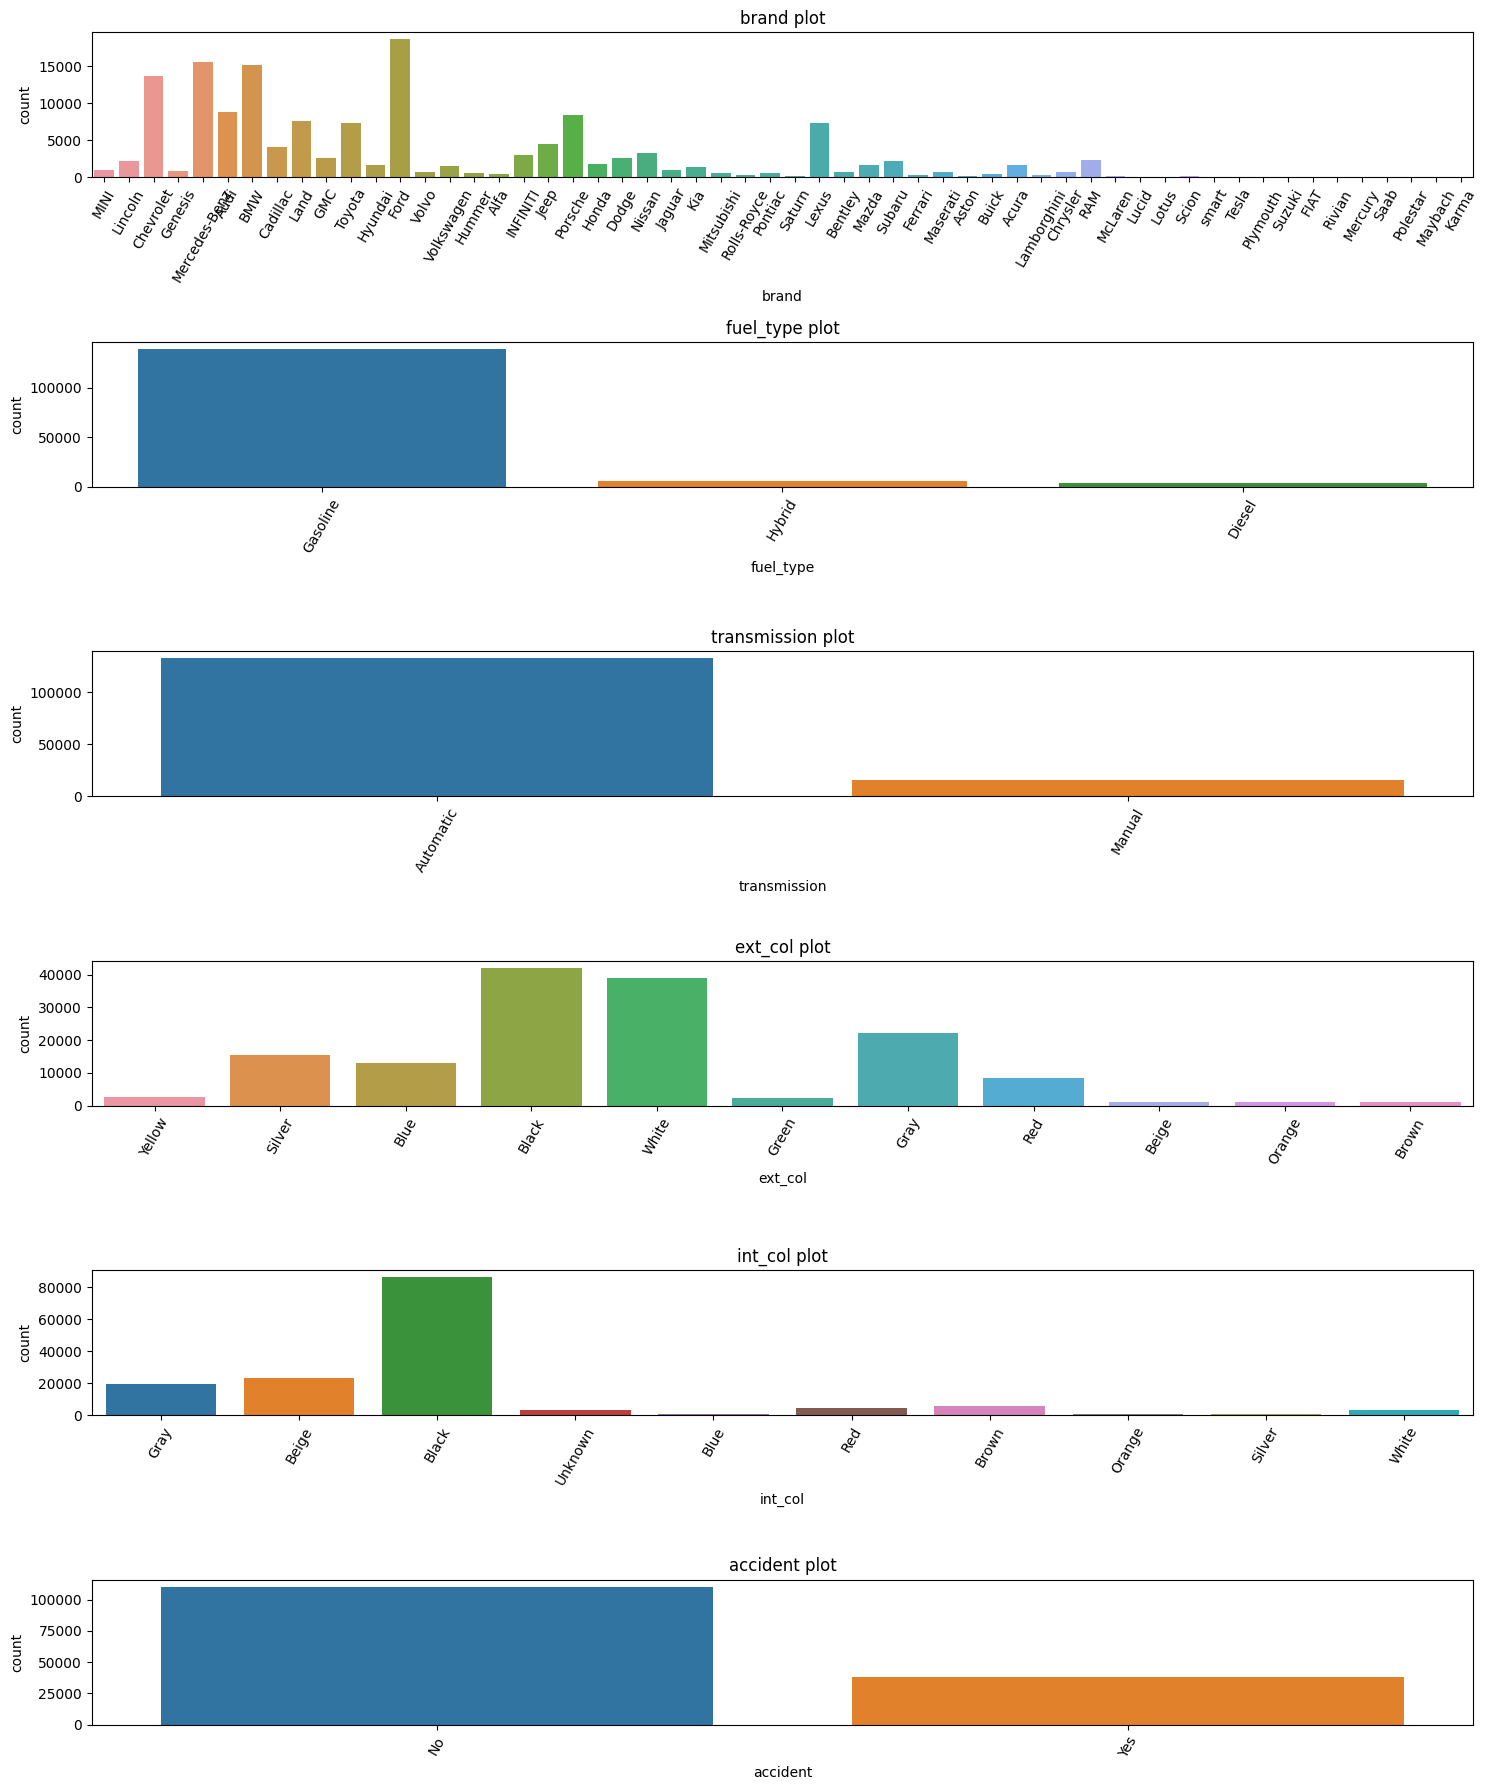

In [33]:
def countplot(dataframe):
    cat_cols = train_df.select_dtypes(include = 'O').columns
    for i, j in enumerate(cat_cols):
        plt.subplot(len(cat_cols), 1, i+1)
        sns.countplot(data = dataframe, x = j)
        plt.title(f"{j} plot")
        plt.xticks(rotation = 60)
    plt.tight_layout()

plt.figure(figsize = (15, 18))
countplot(train_df)

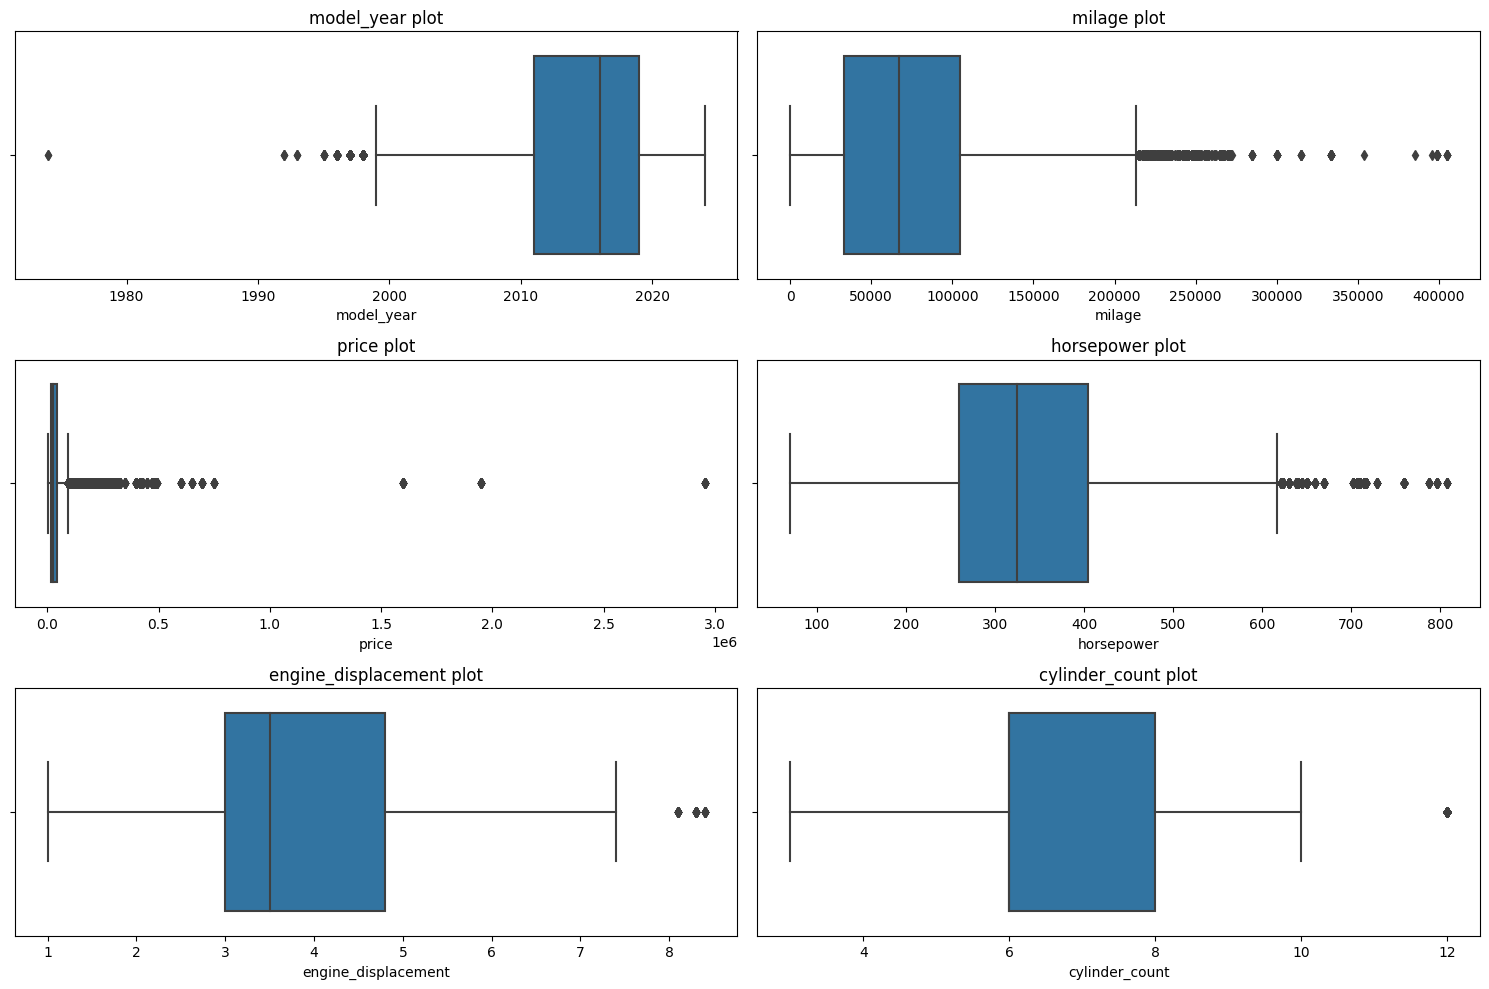

In [34]:
def boxplot(dataframe):
    num_cols = train_df.select_dtypes(exclude = 'O').columns
    for i, j in enumerate(num_cols):
        plt.subplot(len(num_cols)//3 + 1, 2, i+1)
        sns.boxplot(data = dataframe, x = j)
        plt.title(f"{j} plot")
    plt.tight_layout()

plt.figure(figsize = (15, 10))
boxplot(train_df)

<Axes: xlabel='price'>

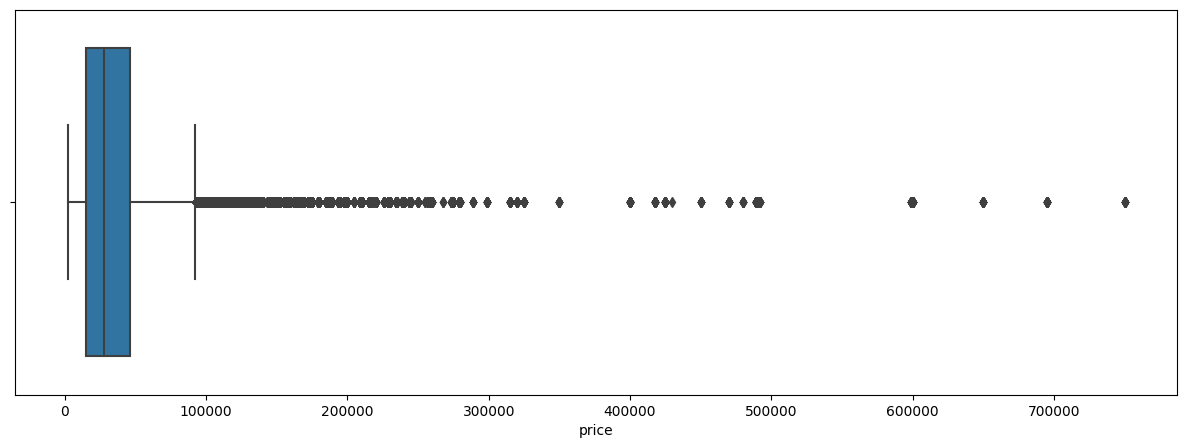

In [35]:
# Removing outlier from the price column

train_df = train_df[train_df.price <= 1_000_000]

plt.figure(figsize = (15, 5))
sns.boxplot(data = train_df, x = "price")

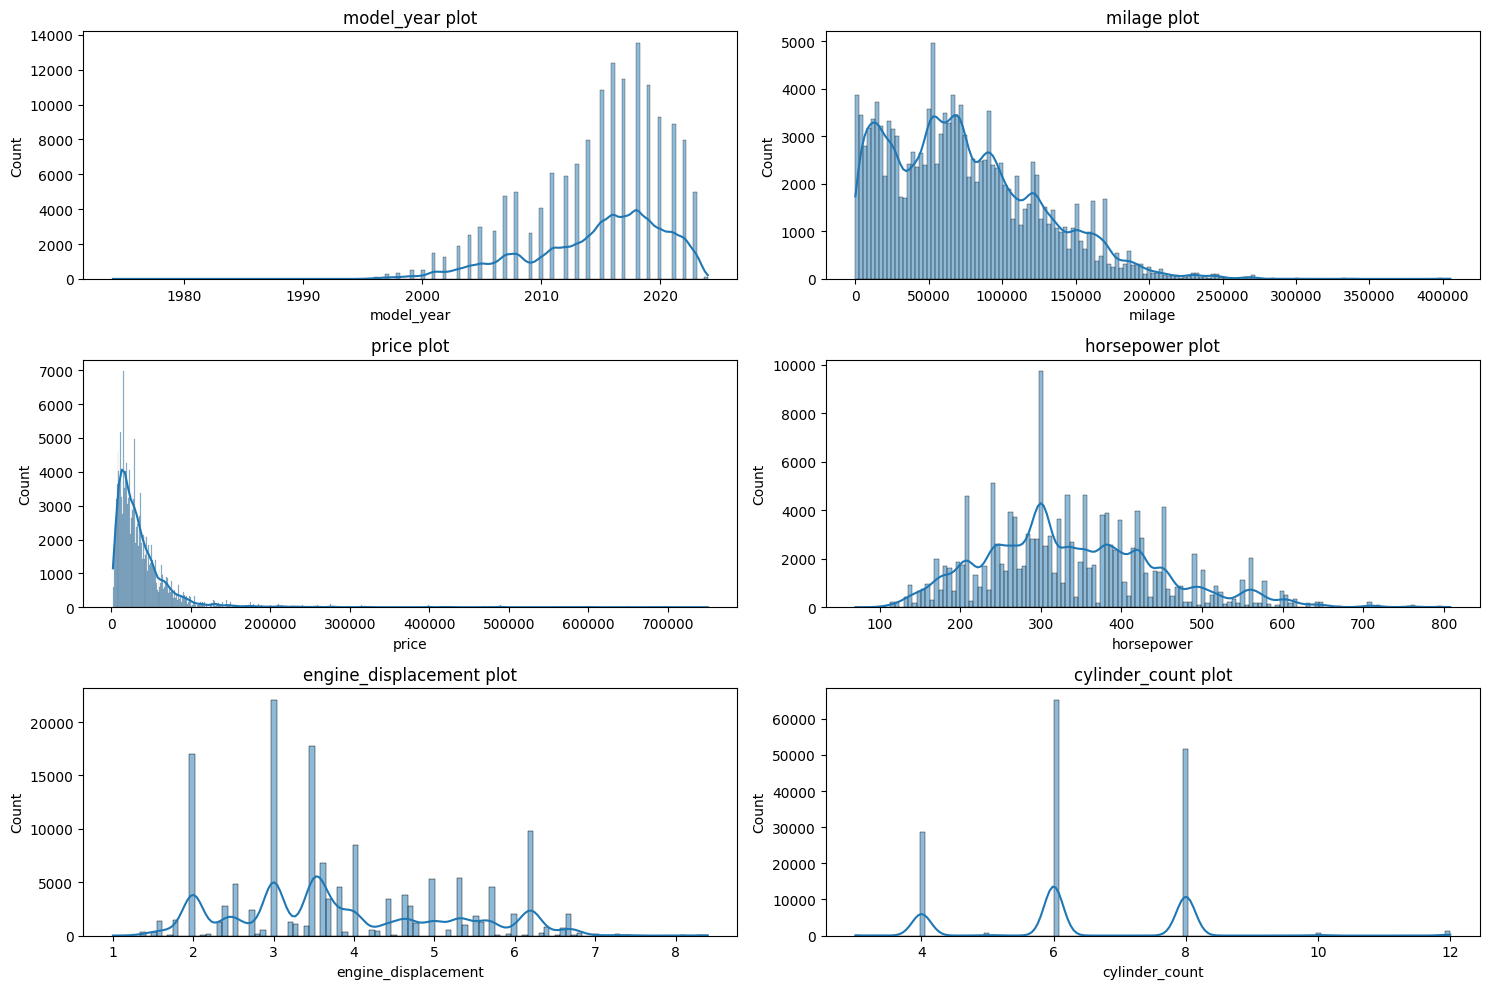

In [36]:
def histplot(dataframe):
    num_cols = train_df.select_dtypes(exclude = 'O').columns
    for i, j in enumerate(num_cols):
        plt.subplot(len(num_cols)//3 + 1, 2, i+1)
        sns.histplot(data = dataframe, x = j, kde = True)
        plt.title(f"{j} plot")
    plt.tight_layout()

plt.figure(figsize = (15, 10))
histplot(train_df)

## Train Test Split and Data Preprocessing

In [37]:
from sklearn.model_selection import train_test_split

X = train_df.drop('price', axis = 1)
y = train_df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

scaler = StandardScaler()
ohe = OneHotEncoder(drop = 'first', sparse_output=False)

preprocessing = ColumnTransformer([
    ("OneHotEncoder", ohe, X_train.select_dtypes(include = 'O').columns), 
    ("StandardScaler", scaler, X_train.select_dtypes(exclude = 'O').columns)
])

X_train_scaled = preprocessing.fit_transform(X_train)
X_test_scaled = preprocessing.transform(X_test)

In [38]:
X_train_scaled[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.  

## Model Building

In [39]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "LassoCV": LassoCV(),
    "RidgeCV": RidgeCV(),
    "ElasticNet": ElasticNet(),
    "ElasticNetCV": ElasticNetCV(),
    "KNN": KNeighborsRegressor(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "GradientBoost": GradientBoostingRegressor(),
    "XGB": XGBRegressor()
}

result_list = []
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    r_score = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    result_dict= {
        "name" : model_name,
        "r2" : r_score,
        "mse": mse,
        "mae" : mae,
        "rmse" : rmse
    }
    result_list.append(result_dict)

metric_df = pd.DataFrame(result_list)
metric_df

,name,r2,mse,mae,rmse
0,Linear Regression,0.300405,1.303731e+09,17046.857285,36107.211787
1,Lasso,0.300335,1.303860e+09,17043.872998,36108.997976
2,Ridge,0.300400,1.303738e+09,17046.389528,36107.318729
3,LassoCV,0.297809,1.308568e+09,17070.412862,36174.132913
4,RidgeCV,0.300400,1.303738e+09,17046.389528,36107.318729
5,ElasticNet,0.270120,1.360168e+09,16959.302578,36880.460517
6,ElasticNetCV,0.052171,1.766326e+09,23004.686062,42027.684341
7,KNN,0.235480,1.424720e+09,16587.539972,37745.463609
8,DecisionTree,-0.328568,2.475851e+09,20734.193729,49757.928984
9,RandomForest,0.259119,1.380668e+09,15987.450844,37157.343579


In [40]:
metric_df.sort_values(['r2', 'mse', 'rmse'], ascending = False)

,name,r2,mse,mae,rmse
11,GradientBoost,0.357843,1.196691e+09,14637.822370,34593.225294
12,XGB,0.336334,1.236774e+09,14772.267227,35167.795984
0,Linear Regression,0.300405,1.303731e+09,17046.857285,36107.211787
4,RidgeCV,0.300400,1.303738e+09,17046.389528,36107.318729
2,Ridge,0.300400,1.303738e+09,17046.389528,36107.318729
1,Lasso,0.300335,1.303860e+09,17043.872998,36108.997976
3,LassoCV,0.297809,1.308568e+09,17070.412862,36174.132913
5,ElasticNet,0.270120,1.360168e+09,16959.302578,36880.460517
9,RandomForest,0.259119,1.380668e+09,15987.450844,37157.343579
7,KNN,0.235480,1.424720e+09,16587.539972,37745.463609



## Hyperparameter Tuning of the model

In [41]:
from sklearn.model_selection import KFold, GridSearchCV

cv = KFold(shuffle=True)

model = GradientBoostingRegressor()

gb_params = {
    "n_estimators": [100, 200],          
    "learning_rate": [0.05, 0.1],        
    "max_depth": [3, 4],                 
    "min_samples_split": [2, 5],         
    "min_samples_leaf": [1, 3],          
    "max_features": [None, "sqrt"]       
}

grid_cv = GridSearchCV(estimator=model, param_grid=gb_params, scoring="neg_root_mean_squared_error", cv= cv, n_jobs=-1, verbose=2)
grid_cv.fit(X_train_scaled, y_train)
y_pred = grid_cv.predict(X_test_scaled)

gb_best = grid_cv.best_estimator_
print("Best Parameters:", grid_cv.best_params_)
print("Best RMSE (CV):", -grid_cv.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END learning_rate=0.05, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END learning_rate=0.05, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.4min
[CV] END learning_rate=0.05, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.2min
[CV] END learning_rate=0.05, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.2min
[CV] END learning_rate=0.05, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 2.4min
[CV] END learning_rate=0.05, max_depth=3, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END learning_rate=0.05, max_depth=3, max_features=None, min_samples_leaf=3, min_samples_split=2, n_

# Prediction on Test Data

In [42]:
test_df.sample(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
18659,207192,Ford,Explorer Platinum,2020,61830,Gasoline,3.0L V6 24V GDI DOHC Twin Turbo,6-Speed Automatic,Gray,Ebony Black,At least 1 accident or damage reported,Yes
23221,211754,Jeep,Gladiator Overland,2020,4000,Gasoline,285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Silver,Black,None reported,Yes
1618,190151,Tesla,Model X Long Range Plus,2020,43534,NaN,534.0HP Electric Motor Electric Fuel System,A/T,Black,Black,NaN,NaN
80829,269362,Saturn,Sky Base,2004,131800,Gasoline,173.0HP 2.7L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes
80195,268728,Porsche,718 Cayman S,2020,4700,Gasoline,350.0HP 2.5L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes


In [43]:
test_df.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

## Data Cleaning


In [44]:
# Removing rows which have Null value in more than 1 columns 
test_df = test_df[test_df.isna().sum(axis = 1) <= 1]

# Accident Column
# As the no of Null values in accident column are very less, so the columns can be dropped
test_df = test_df.dropna(subset = 'accident')

# Fuel Type Column
# Extract word before "Fuel System"
test_df["fuel_type_extracted"] = test_df["engine"].str.extract(r"(\b\w+\b)(?=\s+Fuel System)")

# If no "Fuel System" present, check for known fuel words
test_df["fuel_type_extracted"] = test_df["fuel_type_extracted"].fillna(
    test_df["engine"].str.extract(r"(Electric|Petrol|Diesel|Hybrid|CNG|LPG|Gasoline|Battery)", expand=False)
)

# Fill existing fuel_type only where it's missing
test_df["fuel_type"] = test_df["fuel_type"].fillna(test_df["fuel_type_extracted"])

# Drop helper column if not needed
test_df = test_df.drop(columns="fuel_type_extracted")


test_df = test_df.dropna(subset = "fuel_type")

test_df.clean_title = test_df.clean_title.fillna(test_df.clean_title.mode()[0])

# Extracting information from engine column
# Extract horsepower
test_df["horsepower"] = test_df["engine"].str.extract(r"(\d+(?:\.\d+)?)\s*HP", expand=False)

# Extract engine displacement 
test_df["engine_displacement"] = test_df["engine"].str.extract(r"(\d+(?:\.\d+)?)\s*(?:L|LITER)", expand=False)

# Extract cylinder count
test_df["cylinder_count"] = ( test_df["engine"].astype(str).str.upper().str.extract(
        r"(?:\b(\d+)\s*(?:CYL(?:INDER)?)\b)"      # e.g. "8 Cylinder"
        r"|(?:\bV(\d+)\b)"                        # e.g. "V8"
        r"|(?:\bI(\d+)\b)"                        # e.g. "I4"
        r"|(?:\b(?:STRAIGHT|INLINE|FLAT)\s*(\d+)\b)",  # e.g. "Straight 6"
        expand=True
    )
    .bfill(axis=1)        
    .iloc[:, 0]           
)

test_df["horsepower"] = pd.to_numeric(test_df["horsepower"], errors="coerce")
test_df["engine_displacement"] = pd.to_numeric(test_df["engine_displacement"], errors="coerce")
test_df["cylinder_count"] = pd.to_numeric(test_df["cylinder_count"], errors="coerce").astype("Int64")

test_df = test_df.dropna()

In [45]:
test_df.isnull().sum()

id                     0
brand                  0
model                  0
model_year             0
milage                 0
fuel_type              0
engine                 0
transmission           0
ext_col                0
int_col                0
accident               0
clean_title            0
horsepower             0
engine_displacement    0
cylinder_count         0
dtype: int64

In [46]:
test_df.sample(3)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,horsepower,engine_displacement,cylinder_count
103118,291651,Toyota,Avalon Touring,2008,185000,Gasoline,268.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,5-Speed A/T,Blue,Beige,None reported,Yes,268.0,3.5,6
23289,211822,Chevrolet,Camaro 1LT,2010,134602,Gasoline,312.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,A/T,Brown,Black,None reported,Yes,312.0,3.6,6
106048,294581,BMW,M6 Base,2017,40000,Gasoline,560.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Blue,Black,None reported,Yes,560.0,4.4,8


## Data Transformation

In [47]:
import re
def cleaned_transmission(value):
    val = str(value).upper().strip()

    if re.search(r"\bA/T\b", val) or "AUTOMATIC" in val or "DCT" in val or "DUAL SHIFT MODE" in val or "OVERDRIVE SWITCH" in val or "CVT" in val:
        return "Automatic"
    if re.search(r"\bM/T\b", val) or "MANUAL" in val:
        return "Manual"
    return "Unknown"


test_df.transmission = test_df.transmission.apply(cleaned_transmission)

def cleaned_fuel_type(value):
    val = str(value).strip().upper()

    if val in ["GASOLINE", "E85 FLEX FUEL"]:
        return "Gasoline"
    elif val in ["DIESEL"]:
        return "Diesel"
    elif val in ["HYBRID", "PLUG-IN HYBRID"]:
        return "Hybrid"
    elif val in ["ELECTRIC"]:
        return "Electric"
    else:
        return "Unknown"

test_df["fuel_type"] = test_df["fuel_type"].apply(cleaned_fuel_type)

test_df.accident = test_df.accident.replace({'None reported': "No", "At least 1 accident or damage reported": "Yes"})

def clean_exterior_color(value):
    val = str(value).strip().upper()

    if "BLACK" in val or "ONYX" in val or "RAVEN" in val or "EBONY" in val or "NERO" in val or "BELUGA" in val:
        return "Black"
    elif "WHITE" in val or "ALPINE" in val or "BIANCO" in val or "SNOW" in val or "CHALK" in val or "GLACIER" in val:
        return "White"
    elif "GRAY" in val or "GREY" in val or "GRAPHITE" in val or "STEEL" in val or "SLATE" in val or "THUNDER" in val:
        return "Gray"
    elif "SILVER" in val or "PLATINUM" in val:
        return "Silver"
    elif "RED" in val or "ROSSO" in val or "FLAME" in val or "MAROON" in val:
        return "Red"
    elif "BLUE" in val or "BLU" in val or "AQUA" in val or "NAVY" in val:
        return "Blue"
    elif "GREEN" in val:
        return "Green"
    elif "YELLOW" in val or "GOLD" in val:
        return "Yellow"
    elif "ORANGE" in val:
        return "Orange"
    elif "BROWN" in val or "BRONZE" in val:
        return "Brown"
    elif "BEIGE" in val or "TAN" in val or "CREAM" in val or "IVORY" in val:
        return "Beige"
    elif "PURPLE" in val or "PLUM" in val:
        return "Purple"
    elif "PINK" in val:
        return "Pink"
    elif val in ["–", "-", "NONE", "UNKNOWN", "NOT SUPPORTED"]:
        return "Unknown"
    else:
        return "Unknown"

test_df.ext_col = test_df.ext_col.apply(clean_exterior_color)


def clean_interior_color(value):
    val = str(value).strip().upper()

    if any(x in val for x in ["BLACK", "EBONY", "ONYX", "NERO", "CHARCOAL", "JET", "BLK"]):
        return "Black"
    elif any(x in val for x in ["GRAY", "SLATE", "GRAPHITE", "ASH", "ANTHRACITE", "STONE"]):
        return "Gray"
    elif any(x in val for x in ["BEIGE", "TAN", "CAMEL", "ALMOND", "PARCHMENT", "LINEN", "SAND", "MACCHIATO"]):
        return "Beige"
    elif any(x in val for x in ["BROWN", "CHESTNUT", "BRANDY", "WALNUT", "AMBER", "COGNAC", "MESA", "ARAGON"]):
        return "Brown"
    elif any(x in val for x in ["RED", "HOTSPUR", "MAGMA", "RIOJA"]):
        return "Red"
    elif any(x in val for x in ["BLUE", "NAVY"]):
        return "Blue"
    elif any(x in val for x in ["WHITE", "OYSTER", "ICE", "CLOUD", "PLATINUM"]):
        return "White"
    elif "GREEN" in val:
        return "Green"
    elif "ORANGE" in val:
        return "Orange"
    elif "YELLOW" in val:
        return "Yellow"
    elif "SILVER" in val:
        return "Silver"
    elif val in ["–", "-", "NONE", "UNKNOWN", "NOT SUPPORTED", "N/A"]:
        return "Unknown"
    else:
        return "Unknown"

test_df.int_col = test_df.int_col.apply(clean_interior_color)

# Removing less impacted fuel_type
test_df = test_df[test_df.fuel_type.isin(['Unknown', 'Electric']) == False]

# Removing impacted transmission type
test_df = test_df[test_df.transmission.isin(['Unknown']) == False]

# Removing exterior colors which are less than 20%
test_df = test_df[~test_df.ext_col.isin(['Purple', 'Unknown', 'Pink'])]

# Removing interior colors which are less than 20%
test_df = test_df[~test_df.int_col.isin(['Yellow', 'Green'])]

test_df = test_df.reset_index(drop = True)

In [48]:
test_df_copy = test_df.drop(['id', 'model', 'engine', 'clean_title'], axis = 1)

In [49]:
test_df_copy.sample(3)

,brand,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,horsepower,engine_displacement,cylinder_count
56547,Lexus,2016,60000,Gasoline,Automatic,Gray,Black,Yes,235.0,2.0,4
4533,Lexus,2020,44373,Gasoline,Automatic,White,Black,Yes,295.0,3.5,6
64990,Audi,2020,34300,Hybrid,Automatic,White,Brown,No,335.0,3.0,6


In [50]:
test_df_scaled = preprocessing.transform(test_df_copy)
test_df_scaled[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.  

In [51]:
y_test_pred = gb_best.predict(test_df_scaled)
y_test_pred

array([18774.75138475, 69760.29390501, 31362.9463507 , ...,
       23194.17186996, 16902.73244654, 35827.859579  ])

# Submission

In [52]:
submission = pd.DataFrame({ "id": test_df["id"], "price": y_test_pred})
submission.head()

,id,price
0,188533,18774.751385
1,188534,69760.293905
2,188537,31362.946351
3,188538,16391.563201
4,188539,11220.029387


In [53]:
submission.to_csv("submission.csv", index = False)
print("Submission saved!")

Submission saved!


# Saving the pickle files

In [54]:
import pickle 

# Saving the data preprocessing pipeline 
with open('preprocessing.pkl', 'wb') as file:
    pickle.dump(preprocessing, file)

# Saving the model
with open('model.pkl', "wb") as file:
    pickle.dump(gb_best, file)